# Model Predictive Control

<a id='section01'></a>
## Initialization

In [1]:
# Display graphics inline with the notebook
%matplotlib inline

# Standard Python modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import os
import datetime
import scipy.stats as stats
import pickle

# Modules to display images and data tables
from IPython.display import Image
from IPython.core.display import display

# graphics context
sns.set_context("poster")

## Load Data Sources

In [2]:
dir = '../data/'

# Rainy River Flowrate, units of cubic meters per second
RR = pd.read_pickle(dir+'RR.pkl')

# Rainy Lake Level, units of meters
RL = pd.read_pickle(dir+'RL.pkl')

# Stage-Area function for Rainy Lake, units of ?
area = pd.read_pickle(dir+'area.pkl')['Rainy Lake']

# Stage-Volume function for Rainy Lake, units of millions of cubic meters
volume = pd.read_pickle(dir+'volume.pkl')['Rainy Lake']

# Rule Curves for Rainy Lake, units of meters
RL2000 = pd.read_pickle(dir+'RL2000.pkl')
RL1970 = pd.read_pickle(dir+'RL1970.pkl')

# Discharge Relationship (Thompson, 2014), units of meters
Qdata = pd.DataFrame([
    [335.40,    0.0],
    [336.00,  399.0],
    [336.50,  425.0],
    [336.75,  443.0],
    [337.00,  589.0],
    [337.25,  704.0],
    [337.50,  792.0],
    [337.75,  909.0],
    [338.00, 1014.0],
    [338.50, 1156.0],
    [339.00, 1324.0],
    [339.50, 1550.0],
    [340.00, 1778.0]
])

# Create a function to compute maximum discharge as function of lake elevation
from scipy.interpolate import interp1d
Qmax = interp1d(Qdata[0].map(volume),Qdata[1]*86400/1000000)


#RL2000['DOY'] = RL2000.index.dayofyear

In [3]:
RL2000.tail()

,ELW,LRC,URC,EDL,EHW,AGO
2014-12-27,336.68,337.213333,337.470,336.917647,337.75,337.9
2014-12-28,336.68,337.210000,337.465,336.913235,337.75,337.9
2014-12-29,336.68,337.206667,337.460,336.908824,337.75,337.9
2014-12-30,336.68,337.203333,337.455,336.904412,337.75,337.9
2014-12-31,336.68,337.200000,337.450,336.900000,337.75,337.9


## Utility Plotting Functions

### Rule Curve

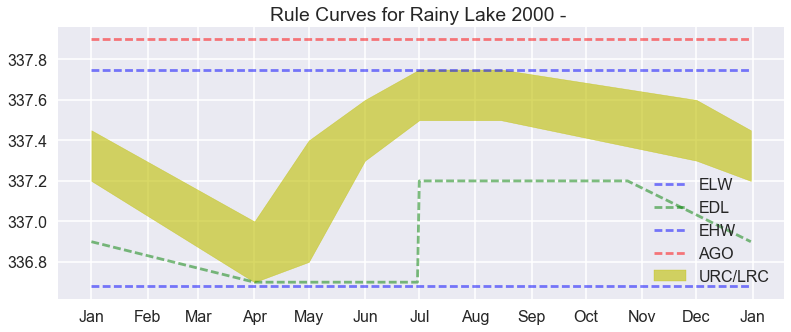

In [4]:
# plot rule curve
def plotRuleCurve(RC):
    plt.plot(RC.index,RC['ELW'],'b--',alpha=0.5)
    plt.plot(RC.index,RC['EDL'],'g--',alpha=0.5)
    plt.plot(RC.index,RC['EHW'],'b--',alpha=0.5)
    plt.plot(RC.index,RC['AGO'],'r--',alpha=0.5)
    plt.fill_between(RC.index, RC['LRC'].tolist(),
        RC['URC'].tolist(), color='y', alpha=0.6)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.legend(['ELW','EDL','EHW','AGO','URC/LRC'],loc='lower right')

plt.figure(figsize=(13,5))
plotRuleCurve(RL2000)
plt.title('Rule Curves for Rainy Lake 2000 - ')

### Historical Inflows

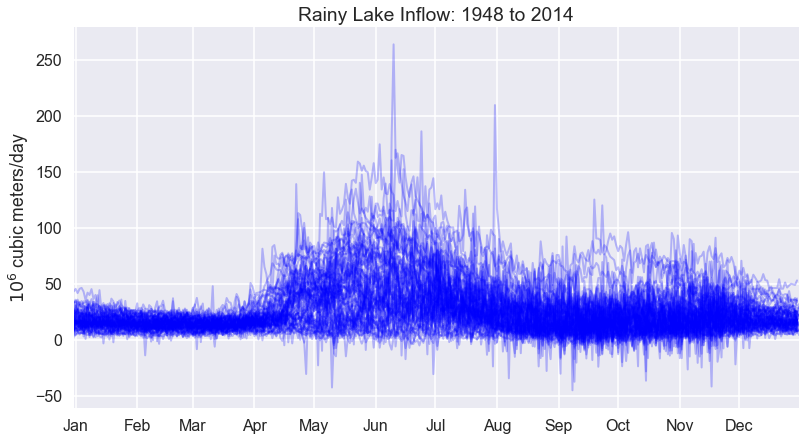

In [5]:
# overlay data onto a single reference year
def plotAnnual(H,color='b'):
    for (yr,r) in H.groupby(H.index.year):
        shift = datetime.datetime(2014,1,1) - datetime.datetime(yr,1,1)
        r = r.tshift(shift.days)
        r.plot(color=color,alpha=0.25,lw=2)

def plotFlow(H,color='b'):
    plotAnnual(H,color=color)
    #RL2000['AGO'].map(Qmax).plot(color='g',lw=3)
    #plt.annotate('AGO Discharge Rate',xy=(16071,1100))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.ylabel('$10^6$ cubic meters/day')
    plt.title('Rainy Lake Inflow: ' + str(min(H.index.year)) + ' to ' + str(max(H.index.year)))

# Compute inflow in units of 10^6 cubic meters/day
Inflow = RR*86400/1e6 + RL.map(volume).diff()
Inflow.fillna(method='backfill',inplace=True)

plt.figure(figsize=(13,7))
plotFlow(Inflow['1948':])

### Historical Levels

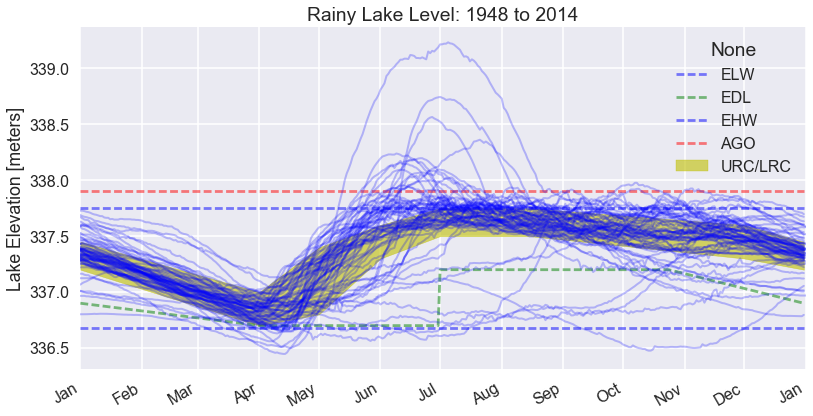

In [6]:
def plotLevel(H,color='b'):
    plotAnnual(H,color=color)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.ylabel('Lake Elevation [meters]')
    plt.title('Rainy Lake Level: ' + str(min(H.index.year)) + ' to ' + str(max(H.index.year)))

plt.figure(figsize=(13,7))
plotRuleCurve(RL2000)
plotLevel(RL['1948':])

### Historical Volume

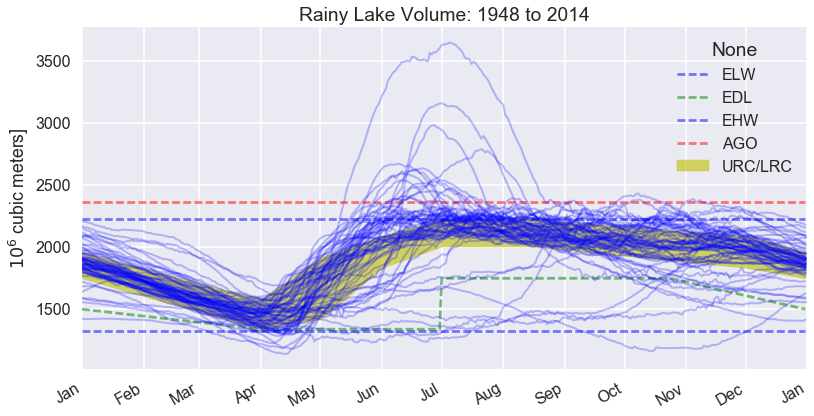

In [7]:
def plotVolume(H,color='b'):
    plotAnnual(H,color=color)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.ylabel('$10^6$ cubic meters]')
    plt.title('Rainy Lake Volume: ' + str(min(H.index.year)) + ' to ' + str(max(H.index.year)))

plt.figure(figsize=(13,7))

vRL2000 = pd.DataFrame()
for col in RL2000.columns:
    vRL2000[col] = RL2000[col].map(volume)
plotRuleCurve(vRL2000)
plotVolume(RL['1948':].map(volume))

### Historical Outflow

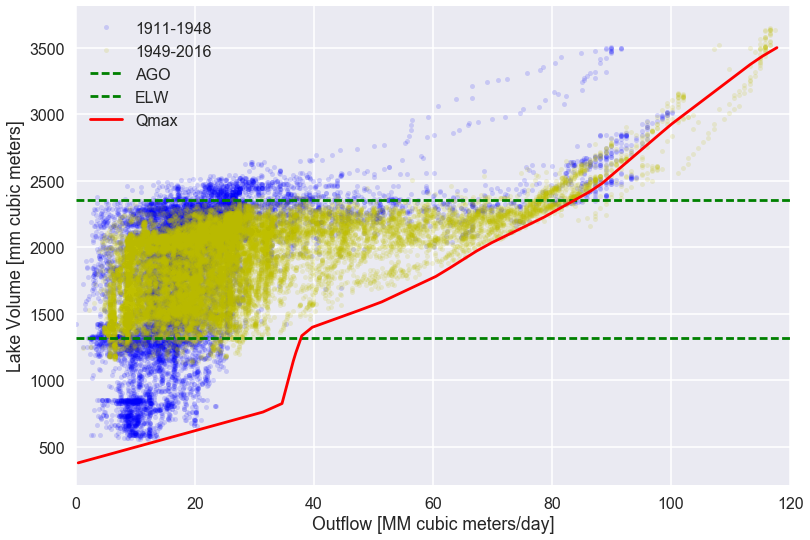

In [8]:
Outflow = RR*86400/1000000
yrA = '1948'

df = pd.DataFrame(RL.map(volume))
df = pd.concat([Outflow,RL.map(volume)],axis=1)
df.columns = ['Outflow','Volume']

plt.plot(df.ix[:yrA,'Outflow'],df.ix[:yrA,'Volume'],'b.',fillstyle='full',ms=10,alpha=0.15)
plt.plot(df.ix[yrA:,'Outflow'],df.ix[yrA:,'Volume'],'y.',fillstyle='full',ms=10,alpha=0.15)
plt.ylabel('Lake Volume [mm cubic meters]')
plt.xlabel('Outflow [MM cubic meters/day]')

vAGO = volume(RL2000['AGO'].mean())
plt.plot([0,120],[vAGO,vAGO],'g--')

vELW = volume(RL2000['ELW'].mean())
plt.plot([0,120],[vELW,vELW],'g--')

v = np.linspace(380,3500)
q = [Qmax(v) for v in v]
plt.plot(q,v,'r')
plt.xlim(0,120)

plt.legend(['1911-1948','1949-2016','AGO','ELW','Qmax'])

## Simulation - Historical Rainy Lake Levels with All Gates Open

NameError: name 'yrB' is not defined

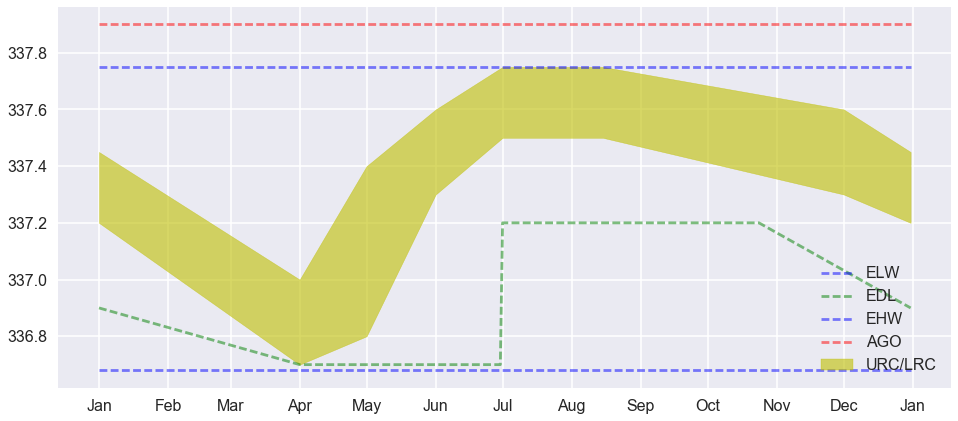

In [9]:
# Plot Minimum Levels
plt.figure(figsize=(16,7))
plotRuleCurve(RL2000)
RL_sim = RL[yrA:yrB].copy()
for d in RL_sim[1:].index:
    netflow = Inflow[d-1]-Qmax(RL_sim[d-1])
    RL_sim[d] = RL_sim[d-1] + netflow*86400/1000000/area(RL_sim[-1])
plotLevel(RL_sim)
print(RL_sim.min())

## Extend Rule Curve over Historical Horizon

In [ ]:
# this creates a rule curve with a time index equal to historical levels data

RC = pd.DataFrame()
for yr,r in RL.groupby(RL.index.year):
    RC = pd.concat([RC,RL2000.tshift((datetime.datetime(yr,1,1) - dateA).days)])
RC['Level'] = RL
RC['Inflow'] = Inflow
RC['Outflow'] = RR

ub = RC['URC']
lb = RC['LRC']
plotLevel(lb)
plotLevel(ub)
plotLevel(RL.ix['1948':])
plotLevel(RL.ix['2014'],color='r')


## Integrating Control

In [ ]:
# Plot Minimum Levels
plt.figure(figsize=(16,7))
plotRC()
RL_sim = RL[yrA:yrB].copy()
print(RC.ix['1949'].tail())
outflow = 250
for d in RL_sim[1:].index:
    print(d,RL_sim[d],RC.ix[d])
    
    #if RL_sim[d-1] > RC.ix[d,'URC']:
        #outflow += 20
    #if RL_sim[d-1] < RC.ix[d,'LRC']:
        #outflow -= 20
    #netflow = Inflow[d-1]-outflow
   # RL_sim[d] = RL_sim[d-1] + netflow*86400/1000000/area(RL_sim[-1])
    
plotLevel(RL_sim)

In [ ]:
RC['Outflow'].groupby(RC.index.year).mean().plot()
RC['Inflow'].groupby(RC.index.year).mean().plot()


In [10]:
fname = '../images/RainyLakeLevels.png'
plt.savefig(fname)
!convert $fname -trim $fname

convert: GeometryDoesNotContainImage `../images/RainyLakeLevels.png' @ warning/attribute.c/GetImageBoundingBox/244.


In [11]:
import gurobipy

In [12]:
from gurobipy import *

# Model data

commodities = ['Pencils', 'Pens']
nodes = ['Detroit', 'Denver', 'Boston', 'New York', 'Seattle']

arcs, capacity = multidict({
  ('Detroit', 'Boston'):   100,
  ('Detroit', 'New York'):  80,
  ('Detroit', 'Seattle'):  120,
  ('Denver',  'Boston'):   120,
  ('Denver',  'New York'): 120,
  ('Denver',  'Seattle'):  120 })

cost = {
  ('Pencils', 'Detroit', 'Boston'):   10,
  ('Pencils', 'Detroit', 'New York'): 20,
  ('Pencils', 'Detroit', 'Seattle'):  60,
  ('Pencils', 'Denver',  'Boston'):   40,
  ('Pencils', 'Denver',  'New York'): 40,
  ('Pencils', 'Denver',  'Seattle'):  30,
  ('Pens',    'Detroit', 'Boston'):   20,
  ('Pens',    'Detroit', 'New York'): 20,
  ('Pens',    'Detroit', 'Seattle'):  80,
  ('Pens',    'Denver',  'Boston'):   60,
  ('Pens',    'Denver',  'New York'): 70,
  ('Pens',    'Denver',  'Seattle'):  30 }

inflow = {
  ('Pencils', 'Detroit'):   50,
  ('Pencils', 'Denver'):    60,
  ('Pencils', 'Boston'):   -50,
  ('Pencils', 'New York'): -50,
  ('Pencils', 'Seattle'):  -10,
  ('Pens',    'Detroit'):   60,
  ('Pens',    'Denver'):    40,
  ('Pens',    'Boston'):   -40,
  ('Pens',    'New York'): -30,
  ('Pens',    'Seattle'):  -30 }

# Create optimization model
m = Model('netflow')

# Create variables
flow = m.addVars(commodities, arcs, obj=cost, name="flow")

# Arc capacity constraints
m.addConstrs(
    (flow.sum('*',i,j) <= capacity[i,j] for i,j in arcs), "cap")

# Equivalent version using Python looping
# for i,j in arcs:
#   m.addConstr(sum(flow[h,i,j] for h in commodities) <= capacity[i,j],
#               "cap[%s,%s]" % (i, j))


# Flow conservation constraints
m.addConstrs(
    (flow.sum(h,'*',j) + inflow[h,j] == flow.sum(h,j,'*')
    for h in commodities for j in nodes), "node")
# Alternate version:
# m.addConstrs(
#   (quicksum(flow[h,i,j] for i,j in arcs.select('*',j)) + inflow[h,j] ==
#     quicksum(flow[h,j,k] for j,k in arcs.select(j,'*'))
#     for h in commodities for j in nodes), "node")

# Compute optimal solution
m.optimize()

# Print solution
if m.status == GRB.Status.OPTIMAL:
    solution = m.getAttr('x', flow)
    for h in commodities:
        print('\nOptimal flows for %s:' % h)
        for i,j in arcs:
            if solution[h,i,j] > 0:
                print('%s -> %s: %g' % (i, j, solution[h,i,j]))

Optimize a model with 16 rows, 12 columns and 36 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+02]
Presolve removed 16 rows and 12 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5000000e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  5.500000000e+03

Optimal flows for Pencils:
Denver -> New York: 50
Denver -> Seattle: 10
Detroit -> Boston: 50

Optimal flows for Pens:
Denver -> Seattle: 30
Detroit -> New York: 30
Detroit -> Boston: 30
Denver -> Boston: 10
